## Violent crimes analysis in Chicago: developing a spatio-temporal dashboard

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import osmnx as ox
import contextily as ctx
import seaborn as sns
import folium
from folium.plugins import HeatMapWithTime
import ipywidgets as widgets
import panel as pn
from IPython.display import display
import matplotlib.font_manager as fm
import numpy as np
from datetime import datetime, timedelta

## Introduction

Violent crimes in Chicago have been on the rise in recent years, with peaks in 2021 and 2022 (Illinois Policy Institute, 2023), but high rates were registered in 2023 as well (Ramos, 2023). Literature on the topic highlights both spatial and socio-economic components in explaining the persistence of these high levels of violence, especially for homicides (Bergh, 2018; Sampson and Morenoff, 2004). 
The main goal of this report and its dashboard is to provide a dynamic and comprehensive visualization of crime data in Chicago for the year 2023, exploring its spatial but also temporal variations. The idea is to explore whether there are correlations in occurrence, type of violent crime and economic conditions of the different areas under analysis. The novelty in this approach consists in adding a temporal component to the picture, which could uncover new patterns in spatial distribution of violent crimes (eg. seasonal effect). As a matter of fact, the Chicago Police department already employs a variety of dashboards (eg https://www.chicago.gov/city/en/sites/vrd/home.html ), but they are still limited to a static view which does not supporting a dynamic approach to the topic. This tool would then be helpful to get a wider understanding of violent crimes’ spread in the city for both law enforcement agencies and policy makers.


## Data

This study uses two primary datasets sources, both from the Open Data portal of the City of Chicago: the "Crimes-2023 dataset" and "Census Data - Selected socioeconomic indicators in Chicago" dataset.


1. Crime data for 2023: this dataset contains each crime registered by the police department from 1st January 2023 till 31st December 2023. It has information on location (points), main category of crime, a short description and date and time of its occurrence. For the sake of this research, the dataset was filtered for violent crimes, which are.	The selection of crime data for 2023 is crucial for understanding the temporal and spatial patterns of criminal activities within Chicago. By examining this dataset, we caexplorern trends, identify high-crime areas, and explore the types of criminal incidents occurring in different neighborhood
2.	Census soocio-economic indicators: this dataset derives from census data and it was produced by the local government to highlight disparities across different community areas. Indeed, the selected indicators encompass various socio-economic measures such as poverty levels, educational attainments, unemployment rates, and housing characteristics. In particular, we are going to focus on median income and share of households under poverty levels by community area. By integrating this data into our analysis, we gain insights into the underlying factors that have a potential influence on where and when violent crimes occur. Before being employed for our analysis, this dataset is merged with a shapefile for community areas’ boundaries (polygons) to plot the selected variables in the maps and in the dashboard.


## Analysis

First of all, we need to import our datasets and go through a little bit of data wrangling to make it ready for visualisation. 

In [2]:
#Load shapefile for community areas boundaries
Chicago_boundaries = 'M:/envs456/Boundaries - Community Areas/geo_export_216a3f50-ae34-4ad1-9cd3-b1d0e45b598d.shp'
gdf = gpd.read_file(Chicago_boundaries)

In [3]:
#Load census data on socio-economic indicators
df_census = pd.read_csv('M:/envs456/below_poverty_level_by_community.csv')

In [4]:
# Preparing for merging
gdf.rename(columns={'community': 'COMMUNITY AREA NAME'}, inplace=True)
df_census['COMMUNITY AREA NAME'] = df_census['COMMUNITY AREA NAME'].str.upper()

In [5]:
# Merge socio-economic indicators with communities boundaries
merged_df = pd.merge(df_census, gdf, on='COMMUNITY AREA NAME', how='inner')

In [6]:
# Convert it to a geodataframe and set Chicago crs
gdf_merged = gpd.GeoDataFrame(merged_df, geometry='geometry')
chicago_crs = 'EPSG:26916'
gdf_merged = gdf_merged.to_crs(chicago_crs)

In [7]:
# Load dataset for dashboard on crime data 2023 Chicago
df = pd.read_csv('M:/envs456/Crimes_-_2023_20240424.csv')

# Drop rows with missing values in Latitude or Longitude columns
df = df.dropna(subset=['Latitude', 'Longitude'])

# Separate date and time
split_result = df['Date'].str.split(' ', expand=True)
df['Date'] = split_result[0]
df['Time'] = split_result[1] + ' ' + split_result[2]  
# Convert date to datetime format
df['Date']= pd.to_datetime(df['Date'])

In [8]:
# Define the list of primary types of crimes to keep
crime_types_to_keep = ['THEFT', 'SEX OFFENSE', 'OFFENSE INVOLVING CHILDREN', 'BATTERY', 
                       'ASSAULT', 'ROBBERY', 'KIDNAPPING', 'CRIMINAL SEXUAL ASSAULT', 'HOMICIDE']
 
# Filter the DataFrame to keep only rows with the specified primary types of crimes
df = df[df['Primary Type'].isin(crime_types_to_keep)]
 
# Now filtered_df contains only the rows with the desired primary types of crimes

In [10]:
# Load Roboto font for the maps
prop = fm.FontProperties(fname='M:/envs456/Roboto-Regular.ttf')

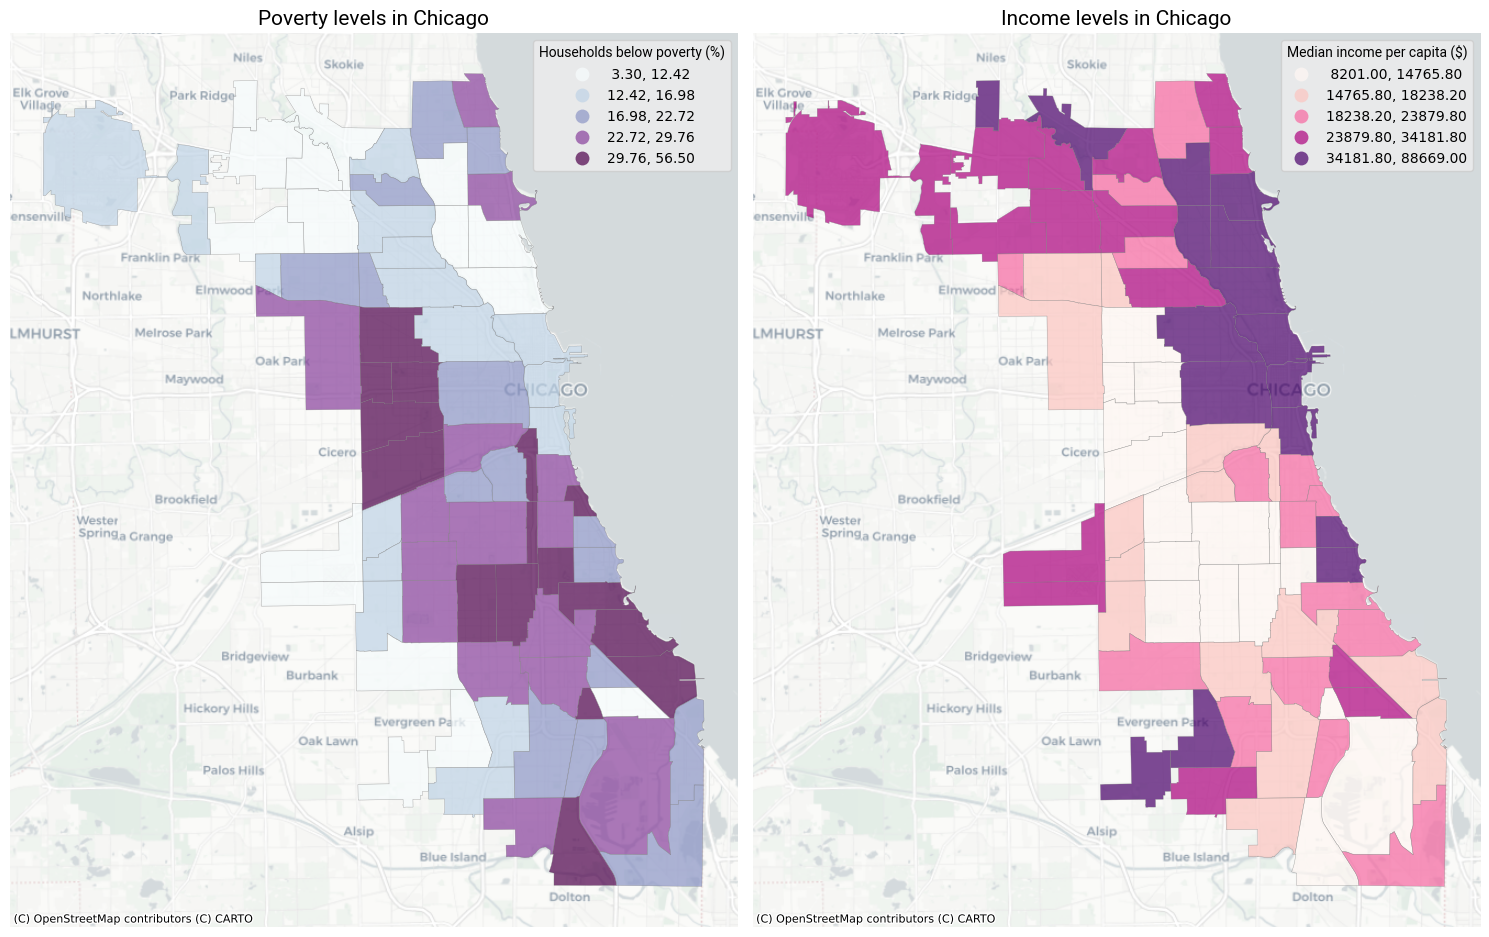

In [11]:
# Static maps
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Map1. Plot percentage of households below poverty with quantile classification
ax1 = gdf_merged.plot(ax=axes[0], column='PERCENT HOUSEHOLDS BELOW POVERTY', cmap='BuPu', edgecolor='grey', linewidth=0.3, alpha=0.7, legend=True, scheme='quantiles', k=5)
ax1.set_axis_off()  # Turn off axis
ctx.add_basemap(ax1, crs=gdf_merged.crs.to_string(), source=ctx.providers.CartoDB.Positron)  
legend1 = ax1.get_legend()  
legend1.set_title('Households below poverty (%)', prop=prop)  
legend1.set_frame_on(True)  
legend1.get_frame().set_facecolor('#EEEEEE')  
ax1.set_title('Poverty levels in Chicago', font=prop, fontsize=15)
              
# Map2. Plot median income with quantile classification
ax2 = gdf_merged.plot(ax=axes[1], column='PER CAPITA INCOME ', cmap='RdPu', edgecolor='grey', linewidth=0.3, alpha=0.7, legend=True, scheme='quantiles', k=5)
ax2.set_axis_off() 
ctx.add_basemap(ax2, crs=gdf_merged.crs.to_string(), source=ctx.providers.CartoDB.Positron)  
legend2 = ax2.get_legend()  
legend2.set_title('Median income per capita ($)', prop=prop)  
legend2.set_frame_on(True)  
legend2.get_frame().set_facecolor('#EEEEEE') 
ax2.set_title('Income levels in Chicago', font=prop, fontsize=15)

# Show maps
plt.tight_layout()
plt.show()

As we can see, there are rather evident spatial disparities in the city; in particular, South Chicago registers both low income and high percentage of poor households, while the central area is on the other side of the spectrum, with high income and low levels of poverty. Some northern parts (such as Uptown and Rodgers Park) show a mixed picture, with both high income and high share of poor households, but overall the situation looks quite segregated, with wealthy areas on a side and deprived areas on the other. 

After this glimpse of the spatial socio-economic inequalities in Chicago, we are ready to go to our Folium dashboard. Violent crime data is presented through an animated heatmap which allows to easily visualise hotspots and their spatio-temporal distribution. The choropleth map for the share of households under the poverty level is kept as a la reference for socio-economic conditions of each area. However, because of a Leaflet bug,  it is not currently possible to overlay it with the heatmap (see https://github.com/python-visualization/folium/issues/767, tried with the suggested solutions but did not work as for other users). We will show it in interactive mode just after the dashboard to make comparisons. 

In [12]:
# HHs below poverty levels panel as reference

map = folium.Map(location=[41.8781, -87.6298], zoom_start=11, tiles='CartoDB positron')

choropleth1 = folium.Choropleth(
    geo_data=gdf_merged,
    name='Percent Households Below Poverty',
    data=merged_df,
    columns=['Community Area Number', 'PERCENT HOUSEHOLDS BELOW POVERTY'],
    key_on='feature.properties.Community Area Number',
    fill_color='PuBu',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Households Below Poverty (%)'
).add_to(map)

choropleth1.add_to(map)

def style_function(feature):
    return {
        "color": "transparent",
        "fillColor": "transparent",
    }

tooltip = folium.features.GeoJsonTooltip(fields=("COMMUNITY AREA NAME","PERCENT HOUSEHOLDS BELOW POVERTY"), aliases=("Community Area:","HHs in poverty %:"))
tooltip_layer = folium.features.GeoJson(gdf_merged, style_function=style_function, tooltip=tooltip)
tooltip_layer.add_to(map)


panel_map = pn.panel(map, width=1200, height=1000)


In [13]:
pn.extension()
 
def create_folium_heatmap_with_time(data, aggregation_method='daily'):
    # Initialize Folium map
    m = folium.Map(location=[41.8781, -87.6298], zoom_start=11, tiles='CartoDB_positron')
 
    # Prepare data for HeatMapWithTime
    heatmap_data = []
    start_date, end_date = None, None
    
    if aggregation_method == 'daily':
        freq = 'D'
    elif aggregation_method == 'weekdays':  # Modified for weekdays aggregation
        freq = 'B'  # Business days (Monday to Friday)
    elif aggregation_method == 'weekends':
        freq = 'W-FRI'  # Weekend starts from Friday
    elif aggregation_method == 'monthly':
        freq = 'M'
    else:  # Default to daily if aggregation method is not recognized
        freq = 'D'
        
    for timestamp, group in data.groupby(pd.Grouper(freq=freq)):
        if aggregation_method == 'weekdays' and timestamp.dayofweek not in [0, 1, 2, 3]:  # Monday to Thursday
            continue
        
        heat_data = group[['Latitude', 'Longitude']].values.tolist()
 
        # Add timestamp to each data point
        heat_data_with_time = [[point[0], point[1], timestamp.strftime('%Y-%m-%d')] for point in heat_data]
        heatmap_data.append(heat_data_with_time)
        
        # Update start and end dates
        if start_date is None or timestamp < start_date:
            start_date = timestamp
        if end_date is None or timestamp > end_date:
            end_date = timestamp
 
    # Create HeatMapWithTime layer
    HeatMapWithTime(heatmap_data, radius=20, auto_play=True, max_opacity=0.7, 
                    gradient={0.20: '#fde725', 
                              0.4: '#5ec962', 
                              0.6: '#21918c',
                              0.8: '#3b528b', 
                              1: '#440154'}).add_to(m)
    
    return m
 
# Update the update_map function to use create_folium_heatmap_with_time
def update_map(df, crime, aggregation_method='daily'):
    # Filter the DataFrame for the selected crime
    data = df[df['Primary Type'] == crime].copy()
    
    # Check if the index of the DataFrame contains timestamps
    if isinstance(data.index, pd.DatetimeIndex):
        # Convert index to timestamp if needed
        data.index = pd.to_datetime(data.index)
    else:
        # If the index is not a timestamp, use another column as the timestamp
        data['timestamp'] = pd.to_datetime(data['Date']) 
        data.set_index('timestamp', inplace=True)
 
    # Create Folium heatmap with time
    folium_map = create_folium_heatmap_with_time(data, aggregation_method)
 
    # Convert Folium map to HTML for display in Panel
    return pn.pane.HTML(folium_map._repr_html_())
 
# Assuming you have a DataFrame 'df' containing crime data
crimes = sorted(df['Primary Type'].unique().tolist())
crimes_selector = pn.widgets.Select(name='Crime', options=crimes)
aggregation_method_selector = pn.widgets.RadioButtonGroup(name='Aggregation Method', 
                                                          options=['Daily', 'Weekdays', 'Weekends', 'Monthly'], 
                                                          value='Daily')
 
@pn.depends(crimes_selector.param.value, aggregation_method_selector.param.value)
def update_components(crime, aggregation_method):
    # Update the map
    map_pane = update_map(df, crime, aggregation_method.lower())
    
    # Use GridSpec for layouts
    grid = pn.GridSpec(width=1200, height=1000)
    grid[0, 0:1] = crimes_selector
    grid[1, 0:1] = aggregation_method_selector
    grid[2:8, :3] = map_pane
    
    return grid
 
# Layout the dashboard
dashboard = pn.Column(update_components, panel_map)
dashboard.servable()

Column
    [0] ParamFunction(function, _pane=GridSpec, defer_load=False)
    [1] Folium(Map, height=1000, sizing_mode='fixed', width=1200)

The interactive elements incorporated into the dashboard enhance user engagement and facilitate deeper exploration of the data. The dashboard offers several elements, such as zooming and panning, enabling users to navigate through the spatio-temporal distribution of violent crimes across Chicago.
Users can zoom in to focus on specific communities or areas of interest, allowing for a more detailed examination of crime hotspots and socio-economic disparities. This zoom functionality makes it easy to explore localised patterns and trends, gaining insights that are not evident at a city-wide scale.
In addition, the dashboard features an auto-play option for the HeatMapWithTime layer, allowing users to observe temporal changes in crime activity for the whole period under analysis. This animated display provides a dynamic perspective on how crime rates change over time, accounting for potential weekend effects, seasonal variations, or long-term trends.

Moreover, the dashboard provides interactive widgets that enable users to customize the analysis. By selecting different crime types or adjusting the aggregation method (daily, monthly, weekdays and weekends), the visualization can be tailored to suit different research objectives. 
The choice of CartoDB Positron as basemap is to enhance a clean design, without much visual clutter but also with enough deatils when zooming in to specific streets and sections of the city for research purposes. 

## References
Bergh, T.V.D., 2018. Crime and Violence in Chicago: A Geography of Segregation and Structural Disadvantage.

City of Chicago - Department of Planning and Development. 2024. Available at: https://www.chicago.gov/city/en/sites/vrd/home.html 

Illinois Policy Institute. 2023. Chicago homicides in 2022 up 43% above pre-pandemic levels. Illinois Policy. Available at: https://www.illinoispolicy.org/chicago-homicides-in-2022-up-43-above-pre-pandemic-levels/ 

Ramos, E. 2023. Here's what's happening with crime in Chicago in 2023. CBS News. Available at: https://www.cbsnews.com/chicago/news/heres-whats-happening-with-crime-in-chicago-in-2023/

Sampson, R.J. and Morenoff, J.D., 2004. Spatial (dis) advantage and homicide in Chicago neighborhoods. Spatially integrated social science, pp.145-170.